### PulsarClassifier.ipynb

 Copyright (C) ‹ 2019 › ‹ Anna Scaife - anna.scaife@manchester.ac.uk › 

This program is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this program. If not, see http://www.gnu.org/licenses/.

---

**[AMS - 190215]**  Notebook created for **Chris Engelbrecht Summer School, Sani Pass, Jan 2019**<br> 
**[AMS - 190910]**  Notebook updated for **CERN School of Computing, Cluj-Napoca, Sept 2019**<br> 
**[AMS - 191015]**  Notebook updated for **DARA Big Data Hackathon, Windhoek, Oct 2019**<br> 
**[AMS - 191023]**  Notebook updated for **VizAfrica Tutorial, Gaborone, Nov 2019**<br> 


This notebook was created for the CHPC/NITheP [2019 Chris Engelbrecht Summer School](https://quantum.ukzn.ac.za/2019-chris-engelbrecht-summer-school/) on the Foundations of Theoretical and Computational Science. It was inspired by [Rob Lyon](http://www.scienceguyrob.com)'s pulsar classification tutorials in the [IAU OAD Data Science Toolkit](https://github.com/astro4dev/OAD-Data-Science-Toolkit/tree/master/Teaching%20Materials/Machine%20Learning/Supervised%20Learning/Examples/PPC).

---

The __learning objectives__ of this tutorial are:

 - visualise feature data in python (matplotlib/seaborn/datashader/holoview)
 - understand train/test splits
 - build a simple random forest classifier
 - understand k-fold validation
 - understand hyper-parameter tuning
 - visualise machine learning evaluation metrics (scikit-plot)
 - visualise feature importances (matplotlib)

---

Keep track of your progress:

- [ ] Exercise 0 (basic)
- [ ] Exercise 1 (basic)
- [ ] Exercise 2 (basic)
- [ ] Exercise 3 (basic)
- [ ] Exercise 4 (basic)
- [ ] Exercise 5 (basic)
- [ ] Exercise 6 (intermediate)
- [ ] Exercise 7 (intermediate)
---

First we import some libraries:

In [2]:
# ___Cell no. 1___
import pandas as pd   # for data handling
import numpy as np    # for array stuff
import matplotlib.pyplot as plt # for plotting stuff
import seaborn as sns # for pretty plotting stuff

We'll use the scikit-learn library for the machine learning tasks, so let's import a whole bunch of stuff from there:

In [3]:
# ___Cell no. 2___
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score

---

We're going to read the [HTRU2 dataset](https://archive.ics.uci.edu/ml/datasets/HTRU2):

In [4]:
# ___Cell no. 3___
df = pd.read_csv('./pulsar.csv')

The first row of the CSV file tells us what the names of the features:

In [5]:
# ___Cell no. 4___

feature_names = df.columns.values[0:-1]

print(feature_names)

['mean_int_pf' 'std_pf' 'ex_kurt_pf' 'skew_pf' 'mean_dm' 'std_dm'
 'kurt_dm' 'skew_dm']


and we can check just how much data we're dealing with:

In [6]:
# ___Cell no. 5___

# Show some information
print ('Dataset has %d rows and %d columns including features and labels'%(df.shape[0],df.shape[1]))

Dataset has 17898 rows and 9 columns including features and labels


We're going to start by separating the numerical feature data from class labels for all the candidates. To get the feature data on its own we can just strip off the column containing the class labels:

In [7]:
# ___Cell no. 6___

features = df.drop('class', axis=1)

The labels for each object tell us abut the target class and we can create an array of those data by extracting the column from the original dataset:

In [8]:
# ___Cell no. 7___

targets = df['class']

Getting the frequency of the classes using NumPy

In [9]:
# ___Cell no. 8___
arr = np.array(targets)
print(arr.shape)
print("noise: "+str(len(np.where(arr == 0)[0])))
print("pulsar: "+str(len(np.where(arr == 1)[0])))

(17898,)
noise: 16259
pulsar: 1639


---

**Exercise 0:** try to use a bar graph for better visualization
<br><br>
##### **hint: use google**
---

Let's take a look at how the two classes are correlated in parameter space. We'll plot the value of one feature against another and colour code the data samples according to their class. Let's start with a pretty basic plot using the matplotlib library:

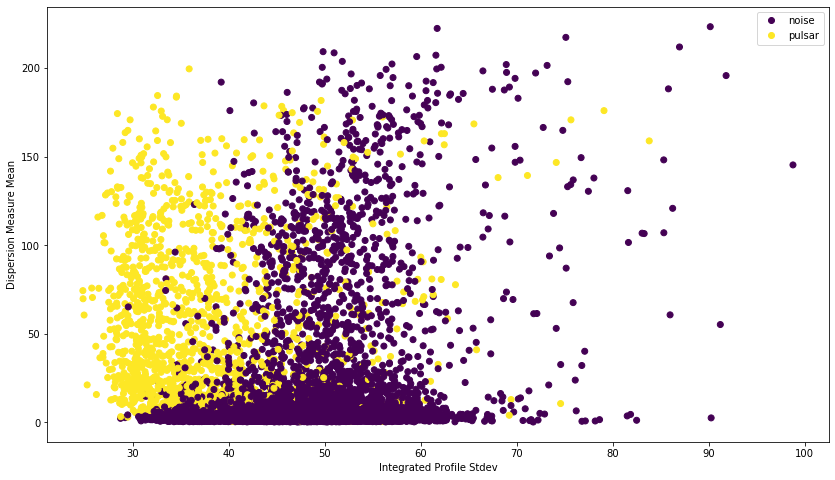

In [10]:
# ___Cell no. 9___

x = [1, 3, 4, 6, 7, 9]
y = [0, 0, 5, 8, 8, 8]
fig = plt.figure(figsize=(14, 8))

classes = ['noise', 'pulsar']

scatter = plt.scatter(df['std_pf'], df['mean_dm'],c=df['class'])
plt.legend(handles=scatter.legend_elements()[0], labels=classes)
plt.xlabel('Integrated Profile Stdev')
plt.ylabel('Dispersion Measure Mean')
plt.show()


for more clarity, we can use scatter density maps from [mpl-scatter-density](https://pypi.org/project/mpl-scatter-density/), where **dpi** (line 6): is an integer that is used to determine the resolution of the density map (change it and have fun).


/users/hussein/source/pulsar_classification/pulsar/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/users/hussein/source/pulsar_classification/pulsar/lib/python3.8/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


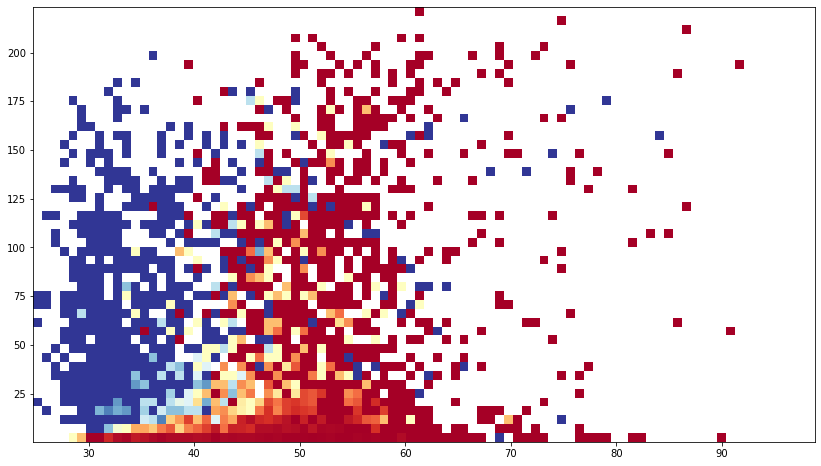

In [11]:
# ___Cell no. 10___

import mpl_scatter_density
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
ax.scatter_density(df['std_pf'], df['mean_dm'],c=df['class'], dpi=10,cmap=plt.cm.RdYlBu)

fig.savefig('gaussian_color_coded.png')

---

**Exercise 1:** try plotting different combinations of features and see if there are any clear divisions.
- hint use [seaborn library](https://seaborn.pydata.org), or a **for loop**
---

-----

Now let's get back to building our classifier. We need to split our labelled data into two separate datasets: one to train the classifier and one to test the fitted machine learning model. 

To do this we can use the function [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) from the [scikit_learn](https://scikit-learn.org) library:

In [14]:
# ___Cell no. 11___

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.33, random_state=66)

---

**Exercise 2:** Once you've run through the tutorial, come back to this point and see what difference changing the relative size of your train:test datasets makes.

---


At this point we now have our dataset in the suitable state to start training our classifier. 

To start with we need to initiate the random forest classifier from [scikit_learn]():

In [15]:
# ___Cell no. 12___

RFC = RandomForestClassifier(n_jobs=2,n_estimators=10)

...and we can immediately fit the machine learning model to our training data:

In [16]:
# ___Cell no. 13___

RFC.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10, n_jobs=2)

---

**Exercise 3:** You could try changing the split criterion from the "gini" ([Gini impurity](https://victorzhou.com/blog/gini-impurity/)) to "entropy" (information gain). Does it make a difference?

---

We can then used the trained classifier to predict the label for the test data that we split out earlier:

In [17]:
# ___Cell no. 14___

rfc_predict = RFC.predict(X_test)

So how did we do? We need to evaluate the performance of our classifier.

A good first step is to evaluate the [cross-validation](https://www.openml.org/a/estimation-procedures/1). This will tell us how well our machine learning model *generalises*, i.e. whether we have over-fitted the training data.

Let's print out the various evaluation criteria:

In [22]:
# ___Cell no. 15___

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc_predict, target_names=['Non Pulsar','Pulsar']))
print('\n')

=== Confusion Matrix ===
[[5327   35]
 [ 105  440]]


=== Classification Report ===
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      5362
      Pulsar       0.93      0.81      0.86       545

    accuracy                           0.98      5907
   macro avg       0.95      0.90      0.92      5907
weighted avg       0.98      0.98      0.98      5907





Although they are useful as they are, a visualisation of these numbers can provide a much more efficient and accessible way to interpret the performance of our classifier.

We can make a more visual representation of the confusion matrix using the [sklearn.metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html) library.

/users/hussein/source/pulsar_classification/pulsar/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


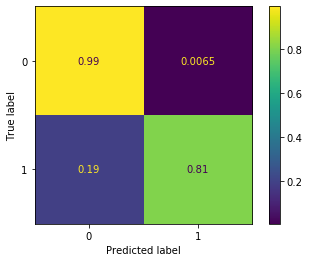

In [23]:
# ___Cell no. 16___

plot_confusion_matrix(RFC, X_test, y_test,normalize='true')

To plot the [ROC curve](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) we need to find the probabilities for each target class separately. We can do this with the [predict_proba]() function:

In [24]:
# ___Cell no. 17___

import scikitplot as skplt
probas = RFC.predict_proba(X_test)

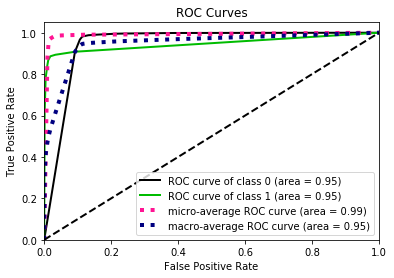

In [25]:
# ___Cell no. 18___

skplt.metrics.plot_roc(y_test, probas)

In a balanced data set there should be no difference between the micro-average ROC curve and the macro-average ROC curve. In the case where there is a class imbalance (like here), if the **macro** ROC curve is *lower* than the micro-ROC curve then there are more cases of mis-classification in minority class. [Longer description here](http://rushdishams.blogspot.com/2011/08/micro-and-macro-average-of-precision.html)

---

**Exercise 4:** What is the ROC curve here telling us?

---

**Exercise 5:** What is the difference between the [RFC.predict( )](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict) function and the [RFC.predict_proba( )](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.predict_proba) function?

---




We can use the output of the RFC.predict_proba( ) function to plot a Precision-Recall Curve. Recall that,

$$Precision = \frac{TP}{TP+FP},$$

$$Recall = \frac {TP}{TP+FN}.$$

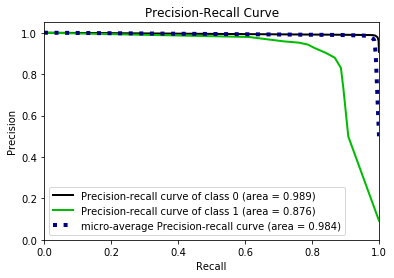

In [27]:
# ___Cell no. 19___

skplt.metrics.plot_precision_recall(y_test, probas)

When we initiated the random forest classifier we picked a value for the number of trees in our forest - but how do we know that this is the best possible value? 

We can use a "grid search" to loop through different options (e.g. number of trees, number of features for each tree, maximum depth of a tree) and tell us which one performs best.

In [28]:
# ___Cell no. 20___

from sklearn.model_selection import RandomizedSearchCV

# number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 10)]

# number of features at every split
max_features = ['auto', 'sqrt']

# max depth
max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
max_depth.append(None)

# create random grid
random_grid = {
 'n_estimators': n_estimators,
 'max_features': max_features,
 'max_depth': max_depth
 }

# Random search of parameters (probably want to increase the iterations here)
rfc_random = RandomizedSearchCV(estimator = RFC, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# Fit the model
rfc_random.fit(X_train, y_train)

# print results
print(rfc_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
{'n_estimators': 2000, 'max_features': 'auto', 'max_depth': 100}


We can then re-run our training with the optimal parameters.

---

**Exercise 6:** Can you re-write the first line of Python in the next cell so that it automatically uses the best parameters?
<br><br>
##### **hint: use google**
---

In [29]:
# ___Cell no. 21___

rfc2 = RandomForestClassifier(n_estimators=733, max_depth=260, max_features='sqrt', n_jobs = 3)
rfc2.fit(X_train,y_train)
rfc2_predict = rfc2.predict(X_test)

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, rfc2_predict))
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, rfc2_predict, target_names=['Non Pulsar','Pulsar']))
print('\n')

=== Confusion Matrix ===
[[5332   30]
 [  90  455]]


=== Classification Report ===
              precision    recall  f1-score   support

  Non Pulsar       0.98      0.99      0.99      5362
      Pulsar       0.94      0.83      0.88       545

    accuracy                           0.98      5907
   macro avg       0.96      0.91      0.94      5907
weighted avg       0.98      0.98      0.98      5907





Let's take a look at the relative importance of the different features that we fed to our classifier:

In [30]:
# ___Cell no. 22___

importances = rfc2.feature_importances_
indices = np.argsort(importances)

...and let's visualise the results:

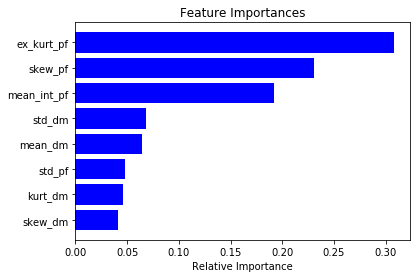

In [33]:
# ___Cell no. 23___

plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), feature_names[indices])
plt.xlabel('Relative Importance')
 
plt.show()

---
looking at the above graph, we can see that we have about 3 significant features. <br>
**Exercise 7:** Use only the 3 most significant features and feed it to a ML model of your choice (optimize the parameters), and compare it with the trained random forest on cell 21. <br><br>
##### **hint: use google**
---

-- THE END --